In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor
from torchsummary import summary
import random
from numpy import load
from tqdm import tqdm, trange
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import pickle
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%run './Attention_based_model.ipynb'

Tue Jul  2 13:19:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8               7W / 320W |    333MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# check the availability of cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device:  cuda (NVIDIA GeForce RTX 4080)


In [3]:
with open('./new_dataset/CIC2018-dataset-all-benign-1000.pkl', 'rb') as f:
    train_data = pickle.load(f)  
train_loader = DataLoader(train_data, batch_size=9, shuffle=True, pin_memory=True)

In [4]:
# device = 'cpu'
NetFormer_model = NetFormer(
  feature_size = 1030,
  d_model=10,
  n_layers=2,
  heads=10,
  dropout=0.1
).to(device)


# NetFormer_model.to(device)
net_lm = Unsupervised_NetFormerLM(NetFormer_model, feature_size=1030).to(device)
# bert_lm.to(device)

net_trainer = NetformerTrainer(net_lm, train_loader,device = 'cuda')
epochs = 9

for epoch in range(epochs):
  net_trainer.train(epoch)

Total Parameters: 24270


EP_train:0:   0%|| 4/841 [00:00<01:26,  9.67it/s]

{'epoch': 0, 'iter': 0, 'loss': 7.342679023742676}


EP_train:0:  60%|| 505/841 [00:22<00:14, 23.01it/s]

{'epoch': 0, 'iter': 500, 'loss': 0.9114945530891418}


EP_train:1:   0%|| 3/841 [00:00<00:36, 22.92it/s]

{'epoch': 1, 'iter': 0, 'loss': 1.0325312614440918}


EP_train:1:  60%|| 504/841 [00:21<00:14, 23.07it/s]

{'epoch': 1, 'iter': 500, 'loss': 0.6877236366271973}


EP_train:2:   0%|| 3/841 [00:00<00:36, 22.78it/s]

{'epoch': 2, 'iter': 0, 'loss': 0.9687013030052185}


EP_train:2:  60%|| 504/841 [00:21<00:14, 22.99it/s]

{'epoch': 2, 'iter': 500, 'loss': 0.8537077903747559}


EP_train:3:   0%|| 3/841 [00:00<00:37, 22.59it/s]

{'epoch': 3, 'iter': 0, 'loss': 1.177020788192749}


EP_train:3:  60%|| 504/841 [00:21<00:14, 22.98it/s]

{'epoch': 3, 'iter': 500, 'loss': 0.7371529936790466}


EP_train:4:   0%|| 3/841 [00:00<00:36, 22.90it/s]

{'epoch': 4, 'iter': 0, 'loss': 1.062574028968811}


EP_train:4:  60%|| 504/841 [00:21<00:14, 23.08it/s]

{'epoch': 4, 'iter': 500, 'loss': 0.7294909954071045}


EP_train:5:   0%|| 3/841 [00:00<00:36, 22.95it/s]

{'epoch': 5, 'iter': 0, 'loss': 0.9048265814781189}


EP_train:5:  60%|| 504/841 [00:21<00:14, 23.05it/s]

{'epoch': 5, 'iter': 500, 'loss': 0.8989659547805786}


EP_train:6:   0%|| 3/841 [00:00<00:36, 22.71it/s]

{'epoch': 6, 'iter': 0, 'loss': 0.9913702011108398}


EP_train:6:  60%|| 504/841 [00:21<00:15, 21.86it/s]

{'epoch': 6, 'iter': 500, 'loss': 0.9598228335380554}


EP_train:7:   0%|| 3/841 [00:00<00:37, 22.26it/s]

{'epoch': 7, 'iter': 0, 'loss': 0.6942890882492065}


EP_train:7:  60%|| 504/841 [00:22<00:14, 22.88it/s]

{'epoch': 7, 'iter': 500, 'loss': 0.9279880523681641}


EP_train:8:   0%|| 3/841 [00:00<00:39, 21.37it/s]

{'epoch': 8, 'iter': 0, 'loss': 0.9077761173248291}


EP_train:8:  60%|| 504/841 [00:22<00:15, 22.45it/s]

{'epoch': 8, 'iter': 500, 'loss': 0.6966851949691772}


EP_train:8: 100%|| 841/841 [00:37<00:00, 22.25it/s]


In [5]:
# Assuming net_lm is your trained model
net_lm.eval()  # Set the model to evaluation mode

# Initialize lists to store outputs and labels
data_points = []
labels = []

with torch.no_grad():
    # progress bar
    data_iter = tqdm.tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        bar_format="{l_bar}{r_bar}"
    )
    for i, data in data_iter:  # Assuming you have an inference data loader
        data = {key: value.to(device) for key, value in data.items()}
        inputs, segment_info, label = data["netformer_input"], data["segment_label"], data["sequence_label"]
        
        last_layer_output = net_lm.netformer(inputs, segment_info)
        
        # Assuming you want to use last_layer_output
        last_layer_output = last_layer_output.cpu().numpy()
        # print(last_layer_output.shape)
        label = label.cpu().numpy()
        
        # Collect the data points and labels
        for j in range(last_layer_output.shape[0]):
            data_points.append(last_layer_output[j])
            labels.append(label[j])

# Convert lists to numpy arrays
data_points_np = np.array(data_points)
labels_np = np.array(labels)

# Optionally save to files
np.save('data_points_benign_training.npy', data_points_np)
np.save('labels_benign_training.npy', labels_np)

# Print shapes to verify
print('Data points shape:', data_points_np.shape)
print('Labels shape:', labels_np.shape)

100%|| 841/841 [00:12<00:00, 65.10it/s]


Data points shape: (7565, 1000, 10)
Labels shape: (7565,)


In [6]:
with open('new_test_set-1000.pkl', 'rb') as f:
    test_data = pickle.load(f)  
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True)

In [7]:
# Assuming net_lm is your trained model
net_lm.eval()  # Set the model to evaluation mode

# Initialize lists to store outputs and labels
data_points = []
labels = []

with torch.no_grad():
    # progress bar
    data_iter = tqdm.tqdm(
        enumerate(test_loader),
        total=len(test_loader),
        bar_format="{l_bar}{r_bar}"
    )
    for i, data in data_iter:  # Assuming you have an inference data loader
        data = {key: value.to(device) for key, value in data.items()}
        inputs, segment_info, label = data["netformer_input"], data["segment_label"], data["sequence_label"]
        
        last_layer_output = net_lm.netformer(inputs, segment_info)
        
        # Assuming you want to use last_layer_output
        last_layer_output = last_layer_output.cpu().numpy()
        label = label.cpu().numpy()
        
        # Collect the data points and labels
        for j in range(last_layer_output.shape[0]):
            data_points.append(last_layer_output[j])
            labels.append(label[j])

# Convert lists to numpy arrays
data_points_np = np.array(data_points)
labels_np = np.array(labels)

# Optionally save to files
np.save('data_points_testing.npy', data_points_np)
np.save('labels_testing.npy', labels_np)

# Print shapes to verify
print('Data points shape:', data_points_np.shape)
print('Labels shape:', labels_np.shape)


100%|| 625/625 [00:16<00:00, 38.91it/s]


Data points shape: (10000, 1000, 10)
Labels shape: (10000,)


In [8]:
from collections import Counter
Counter(labels_np)

Counter({0.0: 5000, 1.0: 5000})

Embeddings shape: (2000, 200, 10)
Labels shape: (2000,)
Flattened Embeddings shape: (2000, 2000)
Epoch [1/50], Loss: 7.9073
Epoch [2/50], Loss: 7.9591
Epoch [3/50], Loss: 7.9424
Epoch [4/50], Loss: 7.9403
Epoch [5/50], Loss: 7.8993
Epoch [6/50], Loss: 7.9415
Epoch [7/50], Loss: 7.9852
Epoch [8/50], Loss: 7.9338
Epoch [9/50], Loss: 7.9597
Epoch [10/50], Loss: 7.9654
Epoch [11/50], Loss: 7.9287
Epoch [12/50], Loss: 7.8818
Epoch [13/50], Loss: 7.9076
Epoch [14/50], Loss: 7.9596
Epoch [15/50], Loss: 7.9300
Epoch [16/50], Loss: 7.9570
Epoch [17/50], Loss: 7.8985
Epoch [18/50], Loss: 7.9318
Epoch [19/50], Loss: 7.9105
Epoch [20/50], Loss: 7.9504
Epoch [21/50], Loss: 7.9098
Epoch [22/50], Loss: 7.9287
Epoch [23/50], Loss: 7.9459
Epoch [24/50], Loss: 7.9238
Epoch [25/50], Loss: 7.9156
Epoch [26/50], Loss: 7.9865
Epoch [27/50], Loss: 7.9862
Epoch [28/50], Loss: 7.9269
Epoch [29/50], Loss: 7.9123
Epoch [30/50], Loss: 7.9033
Epoch [31/50], Loss: 7.9776
Epoch [32/50], Loss: 7.9459
Epoch [33/50], L

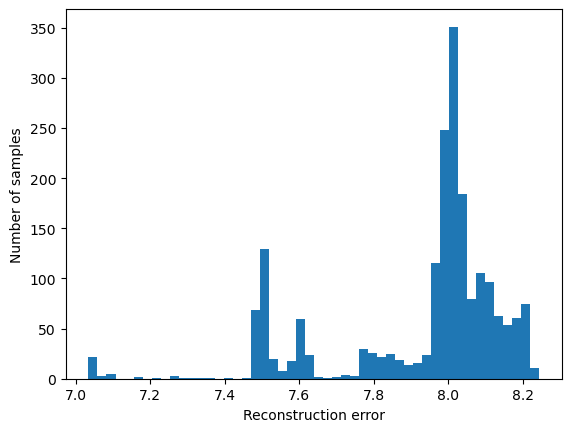

              precision    recall  f1-score   support

         0.0       0.52      0.99      0.68      1000
         1.0       0.90      0.09      0.16      1000

    accuracy                           0.54      2000
   macro avg       0.71      0.54      0.42      2000
weighted avg       0.71      0.54      0.42      2000

[[990  10]
 [910  90]]
ROC AUC Score: 0.6942364999999999


In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the embeddings and labels
embeddings = np.load('data_points_testing.npy')
labels = np.load('labels_testing.npy')

print('Embeddings shape:', embeddings.shape)  # Should be (3188, 2000, 10)
print('Labels shape:', labels.shape)  # Should be (3188,)

# Flatten the embeddings
embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)
print('Flattened Embeddings shape:', embeddings_flattened.shape)  # Should be (3188, 20000)

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = embeddings_flattened.shape[1]
encoding_dim = 256  # Adjust based on your needs

autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Prepare data for training
embedding_tensors = torch.tensor(embeddings_flattened, dtype=torch.float32)
dataset = TensorDataset(embedding_tensors, embedding_tensors)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(embedding_tensors)
    reconstruction_errors = torch.mean((embedding_tensors - reconstructions) ** 2, dim=1).numpy()

# Determine anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)  # Example threshold at the 95th percentile
anomalies = reconstruction_errors > threshold

# Visualize reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.show()

# Evaluate performance
predicted_anomalies = anomalies.astype(int)

print(classification_report(labels, predicted_anomalies))
print(confusion_matrix(labels, predicted_anomalies))
print("ROC AUC Score:", roc_auc_score(labels, reconstruction_errors))


Embeddings shape: (3188, 2000, 10)
Labels shape: (3188,)
PCA Embeddings shape: (3188, 500)
Epoch [1/50], Loss: 6.3394
Epoch [2/50], Loss: 6.1867
Epoch [3/50], Loss: 6.1787
Epoch [4/50], Loss: 6.1552
Epoch [5/50], Loss: 6.1887
Epoch [6/50], Loss: 6.1355
Epoch [7/50], Loss: 6.1262
Epoch [8/50], Loss: 6.0987
Epoch [9/50], Loss: 6.2318
Epoch [10/50], Loss: 6.1320
Epoch [11/50], Loss: 6.1355
Epoch [12/50], Loss: 6.0827
Epoch [13/50], Loss: 6.1829
Epoch [14/50], Loss: 6.1794
Epoch [15/50], Loss: 5.9227
Epoch [16/50], Loss: 6.0908
Epoch [17/50], Loss: 6.1232
Epoch [18/50], Loss: 6.0399
Epoch [19/50], Loss: 6.0562
Epoch [20/50], Loss: 6.0488
Epoch [21/50], Loss: 5.9921
Epoch [22/50], Loss: 6.0726
Epoch [23/50], Loss: 6.0079
Epoch [24/50], Loss: 6.0160
Epoch [25/50], Loss: 6.1949
Epoch [26/50], Loss: 5.9887
Epoch [27/50], Loss: 5.9167
Epoch [28/50], Loss: 6.0004
Epoch [29/50], Loss: 5.8630
Epoch [30/50], Loss: 6.0168
Epoch [31/50], Loss: 5.9937
Epoch [32/50], Loss: 5.8995
Epoch [33/50], Loss: 5

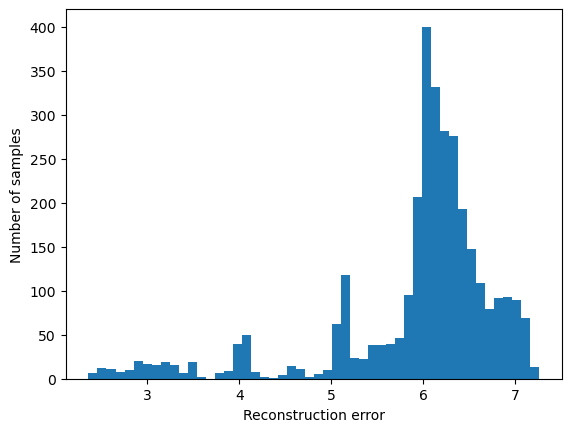

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2756
         1.0       0.01      0.00      0.00       432

    accuracy                           0.81      3188
   macro avg       0.43      0.47      0.45      3188
weighted avg       0.74      0.81      0.78      3188

[[2597  159]
 [ 431    1]]
ROC AUC Score: 0.7044634097994947


In [101]:
### PCA
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the embeddings and labels
embeddings = np.load('data_points.npy')
labels = np.load('labels.npy')

print('Embeddings shape:', embeddings.shape)  # Should be (3188, 2000, 10)
print('Labels shape:', labels.shape)  # Should be (3188,)

# Flatten the embeddings
embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA
pca = PCA(n_components=500)  # Reduce to 500 dimensions, adjust based on your needs
embeddings_pca = pca.fit_transform(embeddings_flattened)

print('PCA Embeddings shape:', embeddings_pca.shape)  # Should be (3188, 500)

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = embeddings_pca.shape[1]
encoding_dim = 128  # Adjust based on your needs

autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Prepare data for training
embedding_tensors = torch.tensor(embeddings_pca, dtype=torch.float32)
dataset = TensorDataset(embedding_tensors, embedding_tensors)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(embedding_tensors)
    reconstruction_errors = torch.mean((embedding_tensors - reconstructions) ** 2, dim=1).numpy()

# Determine anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)  # Example threshold at the 95th percentile
anomalies = reconstruction_errors > threshold

# Visualize reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.show()

# Evaluate performance
predicted_anomalies = anomalies.astype(int)

print(classification_report(labels, predicted_anomalies))
print(confusion_matrix(labels, predicted_anomalies))
print("ROC AUC Score:", roc_auc_score(labels, reconstruction_errors))




In [ ]:
### Sparse

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the embeddings and labels
embeddings = np.load('data_points.npy')
labels = np.load('labels.npy')

print('Embeddings shape:', embeddings.shape)  # Should be (3188, 2000, 10)
print('Labels shape:', labels.shape)  # Should be (3188,)

# Flatten the embeddings
embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)
print('Flattened Embeddings shape:', embeddings_flattened.shape)  # Should be (3188, 20000)

# Define the Sparse Autoencoder architecture
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def loss_function(self, recon_x, x, sparsity_target=0.05, sparsity_weight=1e-3):
        mse_loss = nn.MSELoss()(recon_x, x)
        # L1 regularization
        sparsity_loss = torch.mean(torch.abs(self.encoder[0].weight))
        return mse_loss + sparsity_weight * sparsity_loss

input_dim = embeddings_flattened.shape[1]
encoding_dim = 128  # Adjust based on your needs

sparse_autoencoder = SparseAutoencoder(input_dim, encoding_dim)
optimizer = optim.Adam(sparse_autoencoder.parameters(), lr=0.001)

# Prepare data for training
embedding_tensors = torch.tensor(embeddings_flattened, dtype=torch.float32)
dataset = TensorDataset(embedding_tensors, embedding_tensors)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train the Sparse Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        outputs = sparse_autoencoder(inputs)
        loss = sparse_autoencoder.loss_function(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
sparse_autoencoder.eval()
with torch.no_grad():
    reconstructions = sparse_autoencoder(embedding_tensors)
    reconstruction_errors = torch.mean((embedding_tensors - reconstructions) ** 2, dim=1).numpy()

# Determine anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)  # Example threshold at the 95th percentile
anomalies = reconstruction_errors > threshold

# Visualize reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.show()

# Evaluate performance
predicted_anomalies = anomalies.astype(int)

print(classification_report(labels, predicted_anomalies))
print(confusion_matrix(labels, predicted_anomalies))
print("ROC AUC Score:", roc_auc_score(labels, reconstruction_errors))


Embeddings shape: (3188, 2000, 10)
Labels shape: (3188,)
Flattened Embeddings shape: (3188, 20000)


In [103]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load the embeddings and labels
embeddings = np.load('data_points.npy')
labels = np.load('labels.npy')

print('Embeddings shape:', embeddings.shape)  # Should be (3188, 2000, 10)
print('Labels shape:', labels.shape)  # Should be (3188,)

# Flatten the embeddings
embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)
print('Flattened Embeddings shape:', embeddings_flattened.shape)  # Should be (3188, 20000)

# Normalize the embeddings
embeddings_normalized = (embeddings_flattened - np.mean(embeddings_flattened, axis=0)) / np.std(embeddings_flattened, axis=0)

# Define the Sparse Autoencoder architecture with KL divergence and additional hidden layers
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, sparsity_target=0.05, sparsity_weight=1e-4):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_divergence(self, p, p_hat):
        p_hat = torch.mean(p_hat, dim=0)
        kl_div = p * torch.log(p / (p_hat + 1e-10)) + (1 - p) * torch.log((1 - p) / (1 - p_hat + 1e-10))
        return torch.sum(kl_div)

    def loss_function(self, recon_x, x, encoded):
        mse_loss = nn.MSELoss()(recon_x, x)
        kl_loss = self.kl_divergence(self.sparsity_target, encoded)
        return mse_loss + self.sparsity_weight * kl_loss

input_dim = embeddings_normalized.shape[1]
encoding_dim = 128  # Adjust based on your needs
sparsity_target = 0.05  # Desired average activation of the hidden units
sparsity_weight = 1e-4  # Reduced weight of the sparsity penalty term

sparse_autoencoder = SparseAutoencoder(input_dim, encoding_dim, sparsity_target, sparsity_weight)
optimizer = optim.Adam(sparse_autoencoder.parameters(), lr=0.0001)

# Prepare data for training
embedding_tensors = torch.tensor(embeddings_normalized, dtype=torch.float32)
dataset = TensorDataset(embedding_tensors, embedding_tensors)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train the Sparse Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        encoded, outputs = sparse_autoencoder(inputs)
        loss = sparse_autoencoder.loss_function(outputs, inputs, encoded)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
sparse_autoencoder.eval()
with torch.no_grad():
    _, reconstructions = sparse_autoencoder(embedding_tensors)
    reconstruction_errors = torch.mean((embedding_tensors - reconstructions) ** 2, dim=1).numpy()

# Determine anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)  # Example threshold at the 95th percentile
anomalies = reconstruction_errors > threshold

# Visualize reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.show()

# Evaluate performance
predicted_anomalies = anomalies.astype(int)

print(classification_report(labels, predicted_anomalies))
print(confusion_matrix(labels, predicted_anomalies))
print("ROC AUC Score:", roc_auc_score(labels, reconstruction_errors))


Embeddings shape: (3188, 2000, 10)
Labels shape: (3188,)
Flattened Embeddings shape: (3188, 20000)
Epoch [1/50], Loss: nan
Epoch [2/50], Loss: nan
Epoch [3/50], Loss: nan
Epoch [4/50], Loss: nan
Epoch [5/50], Loss: nan


KeyboardInterrupt: 

In [94]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset
data_points = np.load('data_points.npy')
labels = np.load('labels.npy').astype(int)  # Ensure labels are integers

# Flatten the data points
n_samples, n_features1, n_features2 = data_points.shape
flattened_data_points = data_points.reshape(n_samples, n_features1 * n_features2)

# Apply PCA to reduce dimensionality
for n_components in [10,20,50,100]:  # Test different numbers of components
    pca = PCA(n_components=n_components)
    reduced_data_points = pca.fit_transform(flattened_data_points)

    print(f'Number of PCA components: {n_components}')
    print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}')

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2, random_state=38, n_init=10)  # Use multiple initializations
    predicted_labels = kmeans.fit_predict(reduced_data_points)

    # Since KMeans assigns arbitrary labels (0 or 1) to clusters, we need to map these to actual labels
    def map_clusters_to_labels(true_labels, predicted_clusters):
        label_map = {}
        for cluster in np.unique(predicted_clusters):
            cluster_indices = np.where(predicted_clusters == cluster)[0]
            majority_label = np.argmax(np.bincount(true_labels[cluster_indices]))
            label_map[cluster] = majority_label
        return np.vectorize(label_map.get)(predicted_clusters)

    # Map predicted clusters to actual labels
    mapped_labels = map_clusters_to_labels(labels, predicted_labels)

    # Calculate performance metrics
    precision = precision_score(labels, mapped_labels)
    recall = recall_score(labels, mapped_labels)
    accuracy = accuracy_score(labels, mapped_labels)
    conf_matrix = confusion_matrix(labels, mapped_labels)

    # Handle cases where the confusion matrix has only one row or column
    if conf_matrix.shape == (1, 1):
        conf_matrix = np.array([[conf_matrix[0, 0], 0], [0, 0]])
    elif conf_matrix.shape == (2, 1):
        conf_matrix = np.array([[conf_matrix[0, 0], 0], [conf_matrix[1, 0], 0]])
    elif conf_matrix.shape == (1, 2):
        conf_matrix = np.array([[conf_matrix[0, 0], conf_matrix[0, 1]], [0, 0]])

    false_positive_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])

    # Print performance metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'False Positive Rate: {false_positive_rate:.4f}')
    print('-' * 40)


Number of PCA components: 10
Explained variance ratio: 0.6591
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.8645
False Positive Rate: 0.0000
----------------------------------------


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of PCA components: 20
Explained variance ratio: 0.6674
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.8645
False Positive Rate: 0.0000
----------------------------------------


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of PCA components: 50
Explained variance ratio: 0.6845
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.8645
False Positive Rate: 0.0000
----------------------------------------


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Number of PCA components: 100
Explained variance ratio: 0.7097
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.8645
False Positive Rate: 0.0000
----------------------------------------


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


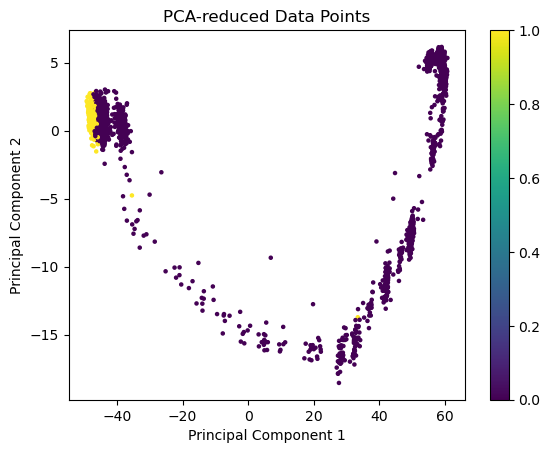

Best Parameters: eps=0.2, min_samples=50
Precision: 0.0000
Recall: 0.0000
Accuracy: 1.0000
False Positive Rate: 0.0000
True Positive (TP): 0
True Negative (TN): 272
False Positive (FP): 0
False Negative (FN): 0
Ratio TP: 0.0000
Ratio TN: 1.0000
Ratio FP: 0.0000
Ratio FN: 0.0000


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset
data_points = np.load('data_points.npy')
labels = np.load('labels.npy').astype(int)  # Ensure labels are integers

# Flatten the data points
n_samples, n_features1, n_features2 = data_points.shape
flattened_data_points = data_points.reshape(n_samples, n_features1 * n_features2)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
reduced_data_points = pca.fit_transform(flattened_data_points)

# Visualize the data
plt.scatter(reduced_data_points[:, 0], reduced_data_points[:, 1], c=labels, cmap='viridis', s=5)
plt.title('PCA-reduced Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Parameter tuning for DBSCAN
eps_values = [0.1, 0.2, 0.5, 1.0, 1.5]
min_samples_values = [3, 5, 10, 50]

best_precision = 0
best_recall = 0
best_accuracy = 0
best_fpr = 0
best_params = (0, 0)

best_tp = 0
best_tn = 0
best_fp = 0
best_fn = 0

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        predicted_labels = dbscan.fit_predict(reduced_data_points)

        # Filter noise points
        filtered_indices = predicted_labels != -1
        if not np.any(filtered_indices):
            continue

        filtered_predicted_labels = predicted_labels[filtered_indices]
        filtered_true_labels = labels[filtered_indices]

        if len(filtered_predicted_labels) == 0:
            continue

        # Since DBSCAN assigns arbitrary labels to clusters, map these to actual labels
        def map_clusters_to_labels(true_labels, predicted_clusters):
            label_map = {}
            for cluster in np.unique(predicted_clusters):
                cluster_indices = np.where(predicted_clusters == cluster)[0]
                majority_label = np.argmax(np.bincount(true_labels[cluster_indices]))
                label_map[cluster] = majority_label
            return np.vectorize(label_map.get)(predicted_clusters)

        # Map predicted clusters to actual labels
        mapped_labels = map_clusters_to_labels(filtered_true_labels, filtered_predicted_labels)

        # Calculate performance metrics
        precision = precision_score(filtered_true_labels, mapped_labels, zero_division=0)
        recall = recall_score(filtered_true_labels, mapped_labels, zero_division=0)
        accuracy = accuracy_score(filtered_true_labels, mapped_labels)
        conf_matrix = confusion_matrix(filtered_true_labels, mapped_labels)

        # Handle cases where the confusion matrix has only one row or column
        if conf_matrix.shape == (1, 1):
            conf_matrix = np.array([[conf_matrix[0, 0], 0], [0, 0]])
        elif conf_matrix.shape == (2, 1):
            conf_matrix = np.array([[conf_matrix[0, 0], 0], [conf_matrix[1, 0], 0]])
        elif conf_matrix.shape == (1, 2):
            conf_matrix = np.array([[conf_matrix[0, 0], conf_matrix[0, 1]], [0, 0]])

        false_positive_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])
        
        tn, fp, fn, tp = conf_matrix.ravel()

        if accuracy > best_accuracy:
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy
            best_fpr = false_positive_rate
            best_params = (eps, min_samples)
            best_tp = tp
            best_tn = tn
            best_fp = fp
            best_fn = fn

# Print best performance metrics and parameters
print(f'Best Parameters: eps={best_params[0]}, min_samples={best_params[1]}')
print(f'Precision: {best_precision:.4f}')
print(f'Recall: {best_recall:.4f}')
print(f'Accuracy: {best_accuracy:.4f}')
print(f'False Positive Rate: {best_fpr:.4f}')
print(f'True Positive (TP): {best_tp}')
print(f'True Negative (TN): {best_tn}')
print(f'False Positive (FP): {best_fp}')
print(f'False Negative (FN): {best_fn}')

# Print ratios
total = best_tp + best_tn + best_fp + best_fn
print(f'Ratio TP: {best_tp / total:.4f}')
print(f'Ratio TN: {best_tn / total:.4f}')
print(f'Ratio FP: {best_fp / total:.4f}')
print(f'Ratio FN: {best_fn / total:.4f}')


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset
data_points = np.load('data_points.npy')
labels = np.load('labels.npy').astype(int)  # Ensure labels are integers

# Flatten the data points
n_samples, n_features1, n_features2 = data_points.shape
flattened_data_points = data_points.reshape(n_samples, n_features1 * n_features2)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust n_components based on your requirement
reduced_data_points = pca.fit_transform(flattened_data_points)

# Apply Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
predicted_labels = spectral.fit_predict(reduced_data_points)

# Map predicted clusters to actual labels
def map_clusters_to_labels(true_labels, predicted_clusters):
    label_map = {}
    for cluster in np.unique(predicted_clusters):
        cluster_indices = np.where(predicted_clusters == cluster)[0]
        majority_label = np.argmax(np.bincount(true_labels[cluster_indices]))
        label_map[cluster] = majority_label
    return np.vectorize(label_map.get)(predicted_clusters)

# Map predicted clusters to actual labels
mapped_labels = map_clusters_to_labels(labels, predicted_labels)

# Calculate performance metrics
precision = precision_score(labels, mapped_labels)
recall = recall_score(labels, mapped_labels)
accuracy = accuracy_score(labels, mapped_labels)
conf_matrix = confusion_matrix(labels, mapped_labels)

# Handle cases where the confusion matrix has only one row or column
if conf_matrix.shape == (1, 1):
    conf_matrix = np.array([[conf_matrix[0, 0], 0], [0, 0]])
elif conf_matrix.shape == (2, 1):
    conf_matrix = np.array([[conf_matrix[0, 0], 0], [conf_matrix[1, 0], 0]])
elif conf_matrix.shape == (1, 2):
    conf_matrix = np.array([[conf_matrix[0, 0], conf_matrix[0, 1]], [0, 0]])

false_positive_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])

# Print performance metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')


/home/binghui/anaconda3/envs/backdoor-attack/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Precision: 0.5499
Recall: 0.9995
Accuracy: 0.5967
False Positive Rate: 0.7945


In [55]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Load the dataset
data_points = np.load('data_points.npy')
labels = np.load('labels.npy').astype(int)  # Ensure labels are integers
print(np.unique(labels))
# Flatten the data points
n_samples, n_features1, n_features2 = data_points.shape
flattened_data_points = data_points.reshape(n_samples, n_features1 * n_features2)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
predicted_labels = kmeans.fit_predict(flattened_data_points)

# Since KMeans assigns arbitrary labels (0 or 1) to clusters, we need to map these to actual labels
# Here we assume that the majority label in each cluster determines the cluster's label
def map_clusters_to_labels(true_labels, predicted_clusters):
    label_map = {}
    for cluster in np.unique(predicted_clusters):
        cluster_indices = np.where(predicted_clusters == cluster)[0]
        majority_label = np.argmax(np.bincount(true_labels[cluster_indices]))
        label_map[cluster] = majority_label
    return np.vectorize(label_map.get)(predicted_clusters)

# Map predicted clusters to actual labels
mapped_labels = map_clusters_to_labels(labels, predicted_labels)

# Calculate performance metrics
precision = precision_score(labels, mapped_labels)
recall = recall_score(labels, mapped_labels)
accuracy = accuracy_score(labels, mapped_labels)
conf_matrix = confusion_matrix(labels, mapped_labels)

# Handle cases where the confusion matrix has only one row or column
if conf_matrix.shape == (1, 1):
    conf_matrix = np.array([[conf_matrix[0, 0], 0], [0, 0]])
elif conf_matrix.shape == (2, 1):
    conf_matrix = np.array([[conf_matrix[0, 0], 0], [conf_matrix[1, 0], 0]])
elif conf_matrix.shape == (1, 2):
    conf_matrix = np.array([[conf_matrix[0, 0], conf_matrix[0, 1]], [0, 0]])

false_positive_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])

# Print performance metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')


[0 1]
Precision: 0.5955
Recall: 0.9991
Accuracy: 0.6653
False Positive Rate: 0.6588


In [ ]:
## DoS 
Number of PCA components: 10
Explained variance ratio: 0.6027
Precision: 0.9706
Recall: 0.9977
Accuracy: 0.9757
False Positive Rate: 0.0897
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.6205
Precision: 0.9706
Recall: 0.9977
Accuracy: 0.9757
False Positive Rate: 0.0897
----------------------------------------
Number of PCA components: 50
Explained variance ratio: 0.6680
Precision: 0.9706
Recall: 0.9977
Accuracy: 0.9757
False Positive Rate: 0.0897
----------------------------------------
Number of PCA components: 100
Explained variance ratio: 0.7325
Precision: 0.9706
Recall: 0.9977
Accuracy: 0.9757
False Positive Rate: 0.0897
----------------------------------------

In [ ]:
## BruteForce
Number of PCA components: 10
Explained variance ratio: 0.5127
Precision: 0.9863
Recall: 1.0000
Accuracy: 0.9884
False Positive Rate: 0.0694
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.5284
Precision: 0.9863
Recall: 1.0000
Accuracy: 0.9884
False Positive Rate: 0.0694
----------------------------------------
Number of PCA components: 50
Explained variance ratio: 0.5673
Precision: 0.9863
Recall: 1.0000
Accuracy: 0.9884
False Positive Rate: 0.0694
----------------------------------------
Number of PCA components: 100
Explained variance ratio: 0.6248
Precision: 0.9863
Recall: 1.0000
Accuracy: 0.9884
False Positive Rate: 0.0694





In [ ]:
### BotNeT

Number of PCA components: 10
Explained variance ratio: 0.4678
Precision: 0.7698
Recall: 0.9993
Accuracy: 0.8099
False Positive Rate: 0.5193
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.4779
Precision: 0.7698
Recall: 0.9993
Accuracy: 0.8099
False Positive Rate: 0.5193
----------------------------------------
Number of PCA components: 50
Explained variance ratio: 0.4960
Precision: 0.7698
Recall: 0.9993
Accuracy: 0.8099
False Positive Rate: 0.5193
----------------------------------------
Number of PCA components: 100
Explained variance ratio: 0.5244
Precision: 0.7698
Recall: 0.9993
Accuracy: 0.8099
False Positive Rate: 0.5193
----------------------------------------

In [ ]:
## Inflation

Number of PCA components: 10
Explained variance ratio: 0.4070
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9995
False Positive Rate: 0.0000
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.4226
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9995
False Positive Rate: 0.0000
----------------------------------------

Number of PCA components: 50
Explained variance ratio: 0.4568
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9995
False Positive Rate: 0.0000
----------------------------------------

Number of PCA components: 100
Explained variance ratio: 0.5074
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9995
False Positive Rate: 0.0000

In [ ]:
## DDoS + Inflation

Number of PCA components: 10
Explained variance ratio: 0.4235
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9985
False Positive Rate: 0.0000
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.4386
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9985
False Positive Rate: 0.0000
----------------------------------------
Number of PCA components: 50
Explained variance ratio: 0.4717
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9985
False Positive Rate: 0.0000
----------------------------------------
Number of PCA components: 100
Explained variance ratio: 0.5207
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.9985
False Positive Rate: 0.0000

In [59]:

## BotNet + infliation 
Number of PCA components: 10
Explained variance ratio: 0.4510
Precision: 0.5951
Recall: 0.9991
Accuracy: 0.6658
False Positive Rate: 0.6554
----------------------------------------
Number of PCA components: 20
Explained variance ratio: 0.4659
Precision: 0.5951
Recall: 0.9991
Accuracy: 0.6658
False Positive Rate: 0.6554
----------------------------------------
Number of PCA components: 50
Explained variance ratio: 0.4840
Precision: 0.5951
Recall: 0.9991
Accuracy: 0.6658
False Positive Rate: 0.6554
----------------------------------------
Number of PCA components: 100
Explained variance ratio: 0.5108
Precision: 0.5951
Recall: 0.9991
Accuracy: 0.6658
False Positive Rate: 0.6554
----------------------------------------


Another 

Best Parameters: eps=0.2, min_samples=3
Precision: 0.7673
Recall: 0.9976
Accuracy: 0.8328
False Positive Rate: 0.3672


SyntaxError: invalid syntax (459084572.py, line 1)

In [ ]:
#